In [1]:
import torch
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme

In [3]:
# custom libraries
import sys, os
print(f"{sys.executable = }")
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../../spaths'))
import sf_nets.datasets.rqp4 as dataset
import utils.spaths as spaths
import utils.mpl_utils as mpl_utils
# from src import systems, dmaps, nets

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/py38/bin/python'


In [4]:
root = Path('..')

# Four dimensional system with rotation and quadratic perturbation

In [5]:
rqp4_ds = dataset.RQP4
rqp4_st = dataset.RQP4System

## Underlying Ornstein-Uhlenbeck SDE

In [6]:
tsep, temp = rqp4_ds.tsep, rqp4_ds.temp
ndim = rqp4_st.ndim

In [7]:
A = -np.diag([1] + [1/tsep]*(ndim-1)) + np.diag([1] + [1/tsep]*(ndim-2), k=1)
print(A)

[[ -1.   1.   0.   0.]
 [  0. -25.  25.   0.]
 [  0.   0. -25.  25.]
 [  0.   0.   0. -25.]]


In [8]:
slow_disp = np.sqrt(2*temp)
fast_disp = np.sqrt(2*temp/tsep)
B = np.diag([slow_disp] + [fast_disp]*(ndim-1))
print(B)

[[0.31622777 0.         0.         0.        ]
 [0.         1.58113883 0.         0.        ]
 [0.         0.         1.58113883 0.        ]
 [0.         0.         0.         1.58113883]]


In [9]:
ou4_sde.nmd

NameError: name 'ou4_sde' is not defined

## Transformation

In [7]:
fwdF = lambda u: jnp.asarray([u[3], u[2], u[1], u[0] + u[1]**2 + u[2]**2])
bwdF = lambda x: jnp.asarray([x[3] - x[2]**2 - x[1]**2, x[2], x[1], x[0]])
F = spaths.SDETransform(fwdF, bwdF)

In [11]:
Fou4_sde = F(ou4_sde)

NameError: name 'ou4_sde' is not defined

## Comparison with explicit system

The equation for the nonlinear system are hard-coded in the `rqp4_ds` class.

In [7]:
rqp4_sde = rqp4_st(tsep, temp).sde

In [8]:
ens0 = np.array([[.2, -.1, .3, .6]], dtype=np.float32)
x0 = ens0.T

In [10]:
np.allclose(rqp4_sde.drif(0, ens0), Fou4_sde.drif(0, ens0)), np.allclose(rqp4_sde.disp(0, ens0), Fou4_sde.disp(0, ens0))

IndexError: index 1 is out of bounds for axis 0 with size 1

The dispersions are the same up to a permutation of columns (it doesn't matter which noises are used for specific coordinates as long as it's consistent).

In [70]:
np.allclose(rqp4_sde.disp(0, ens0), Fou4_sde.disp(0, ens0)[:,:,::-1])

True

## Sample trajectory

In [8]:
rng = np.random.default_rng(rqp4_ds.seed)
rng.integers(10**3, size=10**4);  # warm up of RNG
em = spaths.EulerMaruyama(rng)

In [9]:
ens0 = np.array([rqp4_ds.x0], dtype=np.float32)
Fou4_sol = em.solve(rqp4_sde, ens0, rqp4_ds.tspan, rqp4_ds.dt)

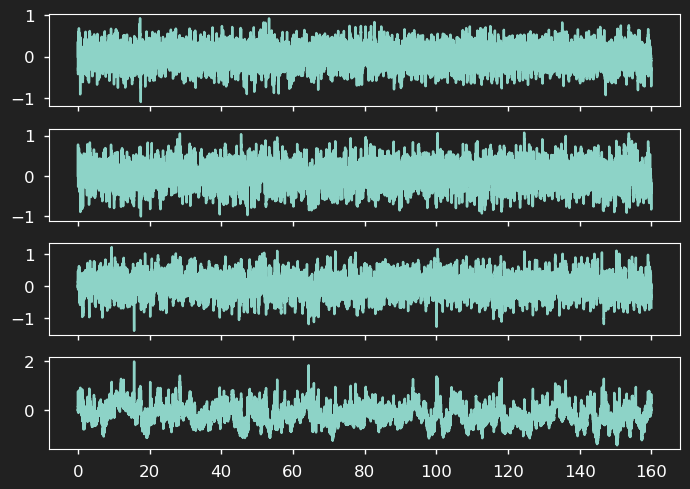

In [10]:
fig, axs = plt.subplots(nrows=4, sharex=True)
for p, ax in zip(Fou4_sol.p[0].T, axs):
    ax.plot(Fou4_sol.t, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [11]:
(times, paths), *rest = rqp4_ds.generate()
# rqp4_sde = rqp4_ds.sde

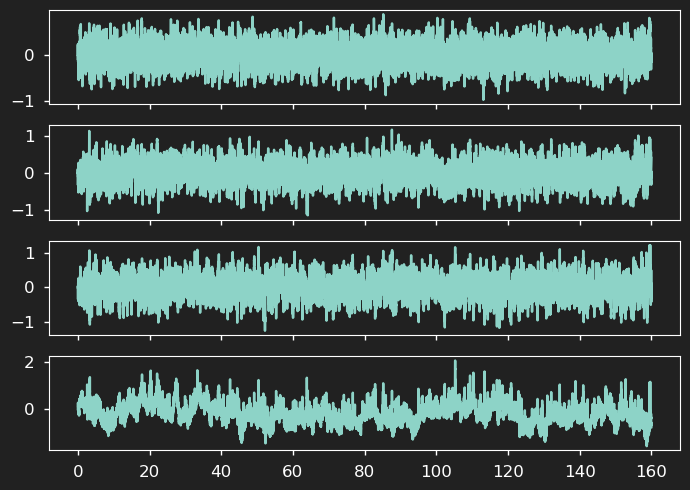

In [12]:
fig, axs = plt.subplots(nrows=4, sharex=True)
for p, ax in zip(paths.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Dataset

In [13]:
train_ds = rqp4_ds(root / 'data', generate=True)
data = train_ds.data
data.shape

torch.Size([8911, 4])

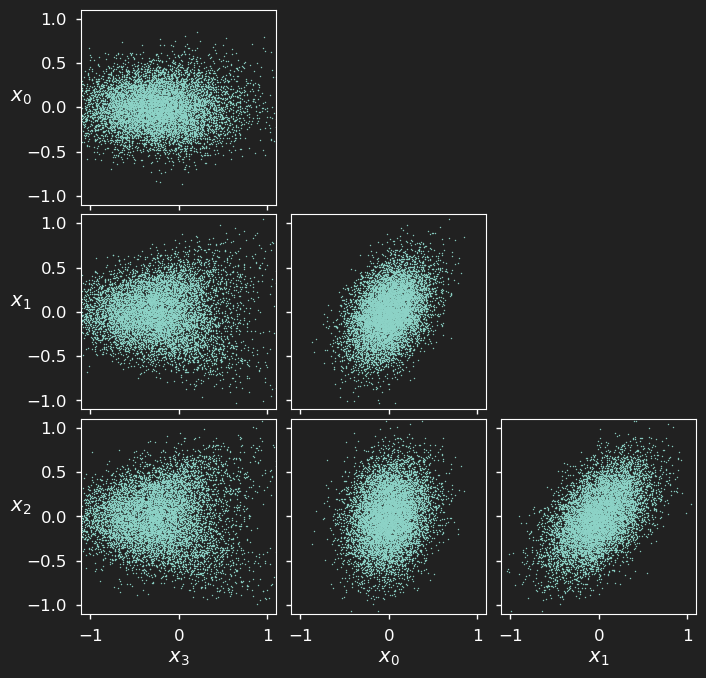

In [14]:
fig = plt.figure(figsize=(8,8))

gs = mpl_utils.coord_grid(fig, data, xylim=[-1.1, 1.1])

plt.show(fig)
plt.close(fig)

## Local noise cloud visualization

In [15]:
burst_dt = rqp4_ds.burst_dt

In [16]:
# seed setting
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3, size=10**4);  # warm up of RNG
# simdat['seed'] = seed

# solver
em = spaths.EulerMaruyama(rng)
# simdat['solver'] = em

### For nonlinear system

In [17]:
t_idx = 300
burst_size = 10**4
point = data[[t_idx]].numpy()
point_rep = np.repeat(point, burst_size, axis=0)
burst_ens = em.burst(rqp4_sde, point_rep, (0.0, 1), burst_dt)
norm_ens = burst_ens - np.mean(burst_ens, axis=0)
print(f"{norm_ens.shape = }")

norm_ens.shape = (10000, 4)


#### Extracting subarrays

See: https://stackoverflow.com/questions/19161512/numpy-extract-submatrix

In [29]:
data_np = data.numpy()
print(data_np[t_idx])
print(data_np[[t_idx]])
print(data_np[np.ix_([t_idx])])

[-0.21401978 -0.2666806   0.03299885 -0.17177463]
[[-0.21401978 -0.2666806   0.03299885 -0.17177463]]
[[-0.21401978 -0.2666806   0.03299885 -0.17177463]]


In [32]:
print(data_np[[t_idx, t_idx+1]])
print(data_np[np.ix_([t_idx, t_idx+1])])

[[-0.21401978 -0.2666806   0.03299885 -0.17177463]
 [-0.18929027  0.28523174  0.6596958  -0.06291468]]
[[-0.21401978 -0.2666806   0.03299885 -0.17177463]
 [-0.18929027  0.28523174  0.6596958  -0.06291468]]


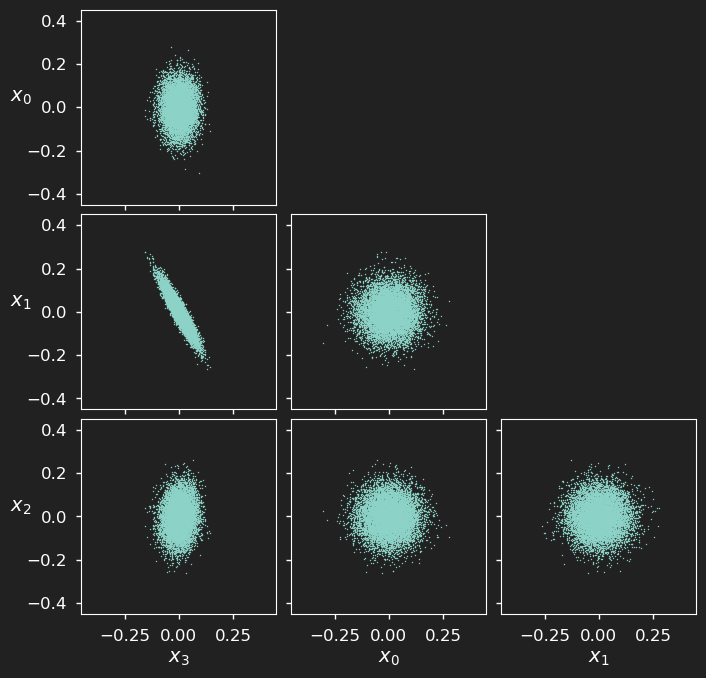

In [18]:
fig = plt.figure(figsize=(8,8))

gs = mpl_utils.coord_grid(fig, norm_ens, xylim=[-.45, .45])

plt.show(fig)
plt.close(fig)

## Sampling slow manifold

In [19]:
def plot_sman(fig, data, sde, nreps, tspan, dt, c=None):
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(len(data), nreps, 4)
    slow_means = np.nanmean(bursts, axis=1)
    mpl_utils.coord_grid(fig, slow_means, xylim=[-1.1, 1.1])
#     plt.scatter(*slow_means.T, s=10)
    
    return slow_means

In [20]:
nreps = 250
proj = train_ds.slow_proj

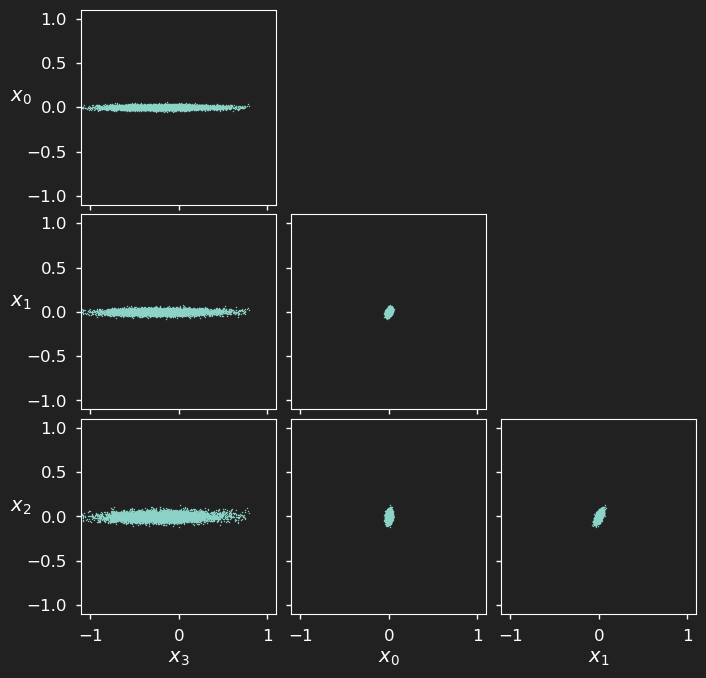

In [21]:
fig = plt.figure(figsize=(8,8))

mpl_utils.coord_grid(fig, proj, xylim=[-1.1, 1.1])
# plot_sman(fig, data[::10], rqp4_sde, nreps, (0, 5*tsep), burst_dt)
# plt.xlim([0,2*np.pi])
# plt.ylim([-4,4])
plt.show()

### For transformed OU process

In [79]:
point_rep = np.repeat(sol.x[t_idx], burst_size, axis=0)
burst_ens = em.burst(Fou4_sde, point_rep, (0.0, 1), burst_dt)
norm_ens = burst_ens - np.mean(burst_ens, axis=0)
print(f"{norm_ens.shape = }")

norm_ens.shape = (10000, 4)


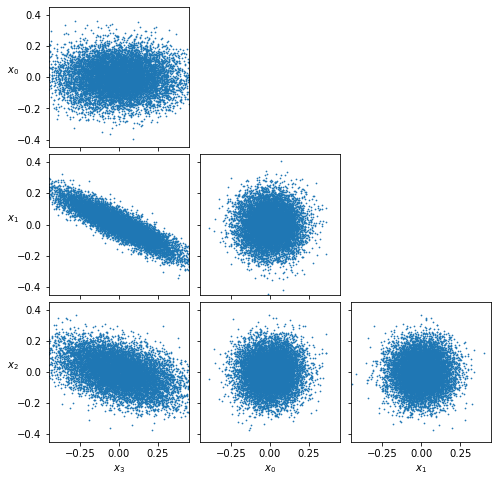

In [78]:
fig = plt.figure(figsize=(8,8))

gs = mpl_utils.coord_grid(fig, norm_ens, xylim=[-.45, .45])

plt.show(fig)
plt.close(fig)

## Spectral decomposition

In [19]:
data = sol.p[0][::5]
data.shape

(8001, 4)

In [20]:
covs = rqp4_sde.diff(0, data)
covs.shape

(8001, 4, 4)

In [1]:
data_evals, data_evecs = zip(*[np.linalg.eigh(cov) for cov in covs])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = np.array(data_evals), np.array(data_evecs)

NameError: name 'covs' is not defined

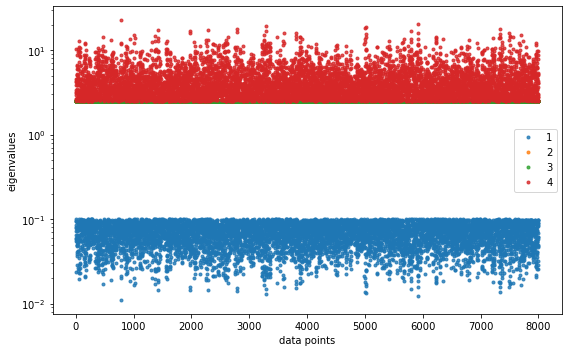

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
for n, e_val in enumerate(data_evals.T):
    ax.plot(e_val, '.', label=f"{n+1}", alpha=.8)
ax.legend()
ax.set_yscale('log')

ax.set_xlabel('data points')
ax.set_ylabel('eigenvalues')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Fiber dynamics

In [70]:
points = data[::10]
points.shape

(801, 4)

In [71]:
burst_size = 10**4
points_rep = np.repeat(points, burst_size, axis=0)
bursts = em.burst(rqp4_sde, points_rep, (0.0, 1), burst_dt).reshape(len(points), burst_size, 4)
mean_points =  bursts.mean(1)
mean_points.shape

(801, 4)

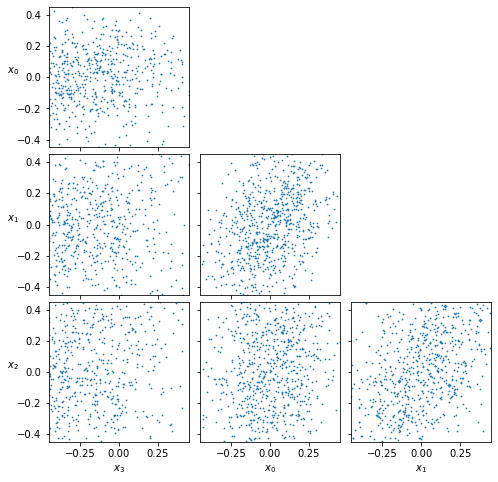

In [72]:
fig = plt.figure(figsize=(8,8))

gs = mpl_utils.coord_grid(fig, mean_points, xylim=[-.45, .45])

plt.show(fig)
plt.close(fig)

## Generate data

In [13]:
# we skip first few samples and from the rest take only part
t_data = sol.t[100::3]

In [14]:
data = np.squeeze(sol(t_data)).astype(dtype=np.float32)  # TODO: use as sol(tt).p[0] with sol(tt) giving a view
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (13301, 4)
data.dtype = dtype('float32')


In [15]:
burst_size = 10**4
covs = dmaps.ln_covs(data, rqp4_sde, em, burst_size, dt)
print(f"{covs.shape = }")
print(f"{covs.dtype = }")

covs.shape = (13301, 4, 4)
covs.dtype = dtype('float32')


In [16]:
data_t = torch.from_numpy(data).float()
covi_t = torch.pinverse(torch.tensor(covs).float(), rcond=1e-10)

## Split and save

In [17]:
train_nsam = int(len(data) * 0.7)
test_nsam = int(len(data) * 0.3)
rest = len(data) - train_nsam - test_nsam

In [18]:
from sklearn.model_selection import train_test_split
data_train, data_test, covi_train, covi_test = train_test_split(data_t, covi_t, test_size=0.33, random_state=42)

In [21]:
type(data_test)

torch.Tensor

In [23]:
torch.save((data_train, covi_train), f"{path}/train.pt")
torch.save((data_test, covi_test), f"{path}/test.pt")

In [17]:
dataset = nets.SimpleLabeledDataset(data_t, covi_t)
train_dataset, valid_dataset, _ = torch.utils.data.random_split(dataset, (train_nsam, valid_nsam, rest))

In [18]:
print(f"{len(train_dataset) = }")
print(f"{len(valid_dataset) = }")

len(train_dataset) = 9310
len(valid_dataset) = 3990


In [19]:
torch.save(train_dataset, "../data/rqp4/train.pt")
torch.save(valid_dataset, "../data/rqp4/valid.pt")

In [20]:
torch.save(simdat, "../data/rqp4/simdat.pt")